# Exploración de datos

Este notebook es para  estudiar la influencia del fenómeno el niño-oscilación del sur (enos) en sus fases extremas en las lluvias y los movimientos en masa en el municipio taminango (nariño) en el periodo 2000-2019.

In [1]:
"""
GeoEnos Lab Data Module.

Este módulo contiene funciones y análisis para trabajar con datos de GeoEnos Lab.
Incluye métodos para cargar, procesar y visualizar datos relacionados con estudios 
geológicos y ambientales.
"""
import os

import contextily as ctx
import geopandas as gpd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
from adjustText import adjust_text
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.spatial import Delaunay, Voronoi
from shapely.geometry import LineString, Point, Polygon

In [2]:
def get_stations_dict(path_data):
    """get_stations_dict.

    get the stations from the csv file

    Parameters
    ----------
    pathData : str
        location of the csv file

    Returns
    -------
    station_dict: dict
        stations dictionary
    """
    df_lluvias = pd.read_csv(path_data)
    station_dict = {}
    for _, row in df_lluvias.drop_duplicates(subset=["NombreEstacion"]).iterrows():
        name_key = row["NombreEstacion"].split(" [")[0].replace(" ", "_")
        coords = (round(row["Latitud"], 2), round(row["Longitud"], 2))
        station_dict[name_key] = coords
    return station_dict

In [26]:
def get_landslides_dict(dataframe_landslides, all_points):
    """get_landslides_dict.

    get the landslides from the Dataframe

    Parameters
    ----------
    dataframe : Dataframe
        DataFrame containing the landslides data.

    Returns
    -------
    landslides_dict: dict
        Landslides dictionary with Serial as keys and coordinates as values.
    """
    landslides_dict = {}
    for _, row in dataframe_landslides.drop_duplicates(subset=["Serial"]).iterrows():
        if all_points:
            name_key = row["Serial"].replace(" ", "_")
        else:
            name_key = row["Municipio"].replace(" ", "_")
        coords = (round(row["latitud"], 2), round(row["longitud"], 2))
        landslides_dict[name_key] = coords
    return landslides_dict

In [27]:
data_original_lluvias1 = "../data/Original/IDEAM/LLuvias1.csv"
data_original_lluvias2 = "../data/Original/IDEAM/LLuvias2.csv"

estaciones_lluvias1 = get_stations_dict(data_original_lluvias1)
estaciones_lluvias2 = get_stations_dict(data_original_lluvias2)

estaciones = {**estaciones_lluvias1, **estaciones_lluvias2}

print(f"Total de estaciones: {len(estaciones)} y son: {estaciones}")

Total de estaciones: 16 y son: {'AEROPUERTO_ANTONIO_NARINO': (1.39, -77.29), 'AEROPUERTO_LA_FLORIDA': (1.8, -78.77), 'AEROPUERTO_SAN_LUIS_-_AUT': (0.86, -77.68), 'ALTAQUER_-_AUT': (1.25, -78.09), 'APONTE': (1.4, -77.03), 'BARBACOAS': (1.67, -78.14), 'CHARCO_EL': (2.44, -78.09), 'COCO_EL': (1.63, -78.63), 'CUMBAL': (0.91, -77.79), 'LLANO_VERDE': (1.74, -77.53), 'NARINO': (1.28, -77.36), 'PUERRES': (0.89, -77.5), 'REMOLINO_GRANDE': (2.19, -78.42), 'SAN_JOSE_DE_TAPAJE': (2.08, -78.11), 'SANDONA': (1.32, -77.48), 'SANTA_ROSA_POTOSI': (0.82, -77.57)}


In [28]:
# Configurar osmnx para que devuelva un GeoDataFrame
# Configurar ajustes globales directamente con el módulo settings
ox.settings.use_cache = True
ox.settings.log_console = True

folder_path = "../data/maps/"

# Crea la carpeta si no existe
os.makedirs(folder_path, exist_ok=True)


# Define la ruta del archivo shapefile
shapefile_path = os.path.join(folder_path, "narino.shp")

# Verifica si el archivo existe
if not os.path.exists(shapefile_path):
    # Si el archivo no existe, obtiene los datos y guarda en el archivo shapefile
    gdf = ox.geocode_to_gdf("Nariño, Colombia")
    # Guarda en un archivo shapefile
    gdf = gdf.rename(columns={col: col[:10] for col in gdf.columns})
    gdf.to_file(shapefile_path)
    print(f"Archivo guardado en {shapefile_path}")
else:
    print(f"El archivo ya existe en {shapefile_path}")

El archivo ya existe en ../data/maps/narino.shp


In [29]:
# Cargar el shapefile
gdf = gpd.read_file("../data/maps/Narino.shp")
# Filtrar para obtener solo el departamento de Nariño
narino_map = gdf[gdf["name"] == "Nariño"]

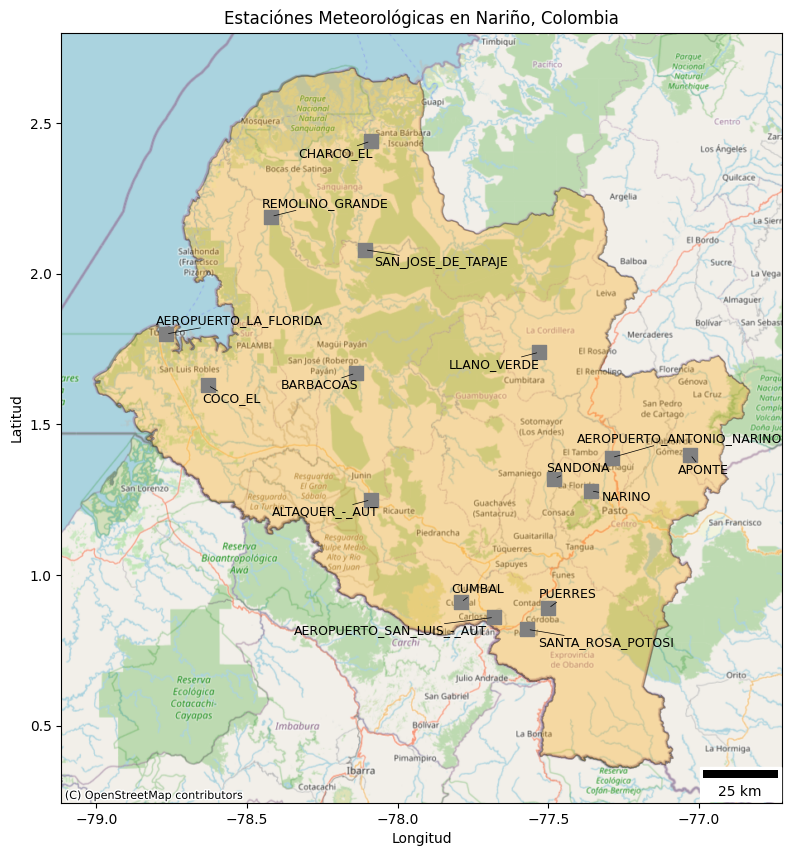

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_ylabel("Latitud")
ax.set_xlabel("Longitud")
ax.set_title("Estaciónes Meteorológicas en Nariño, Colombia")
ax.add_artist(ScaleBar(100000, "m", location="lower right"))

# Plotear el departamento
narino_map.plot(ax=ax, alpha=0.3, edgecolor="k", facecolor="orange")

texts = []
# Agregar cada punto al mapa
for name, (lat, lon) in estaciones.items():
    ax.scatter(lon, lat, color="grey", s=100, marker="s")
    texts.append(ax.text(lon, lat, name, fontsize=9, ha="center", va="center"))

adjust_text(
    texts,
    expand=(
        1.2,
        2,
    ),  # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
    arrowprops=dict(
        arrowstyle="-", color="k", lw=0.5
    ),  # ensure the labeling is clear by adding arrows
)
# Añadir el mapa base usando OpenStreetMap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Mostrar el mapa
plt.show()

In [31]:
dtype_dict = {
    "Serial": "string",
    "Event": "category",
    "Departamento": "category",
    "Municipio": "category",
    "Annio": "int64",
    "Mes": "int64",
    "dia": "int64",
}
# Leer el archivo CSV
# Reemplaza 'ruta_del_archivo.csv' con la ruta a tu archivo CSV
df_deslizamientos = pd.read_csv(
    "../data/processed/DESINVENTAR/Add_cordinates_desinventar_narino.csv",
    dtype=dtype_dict,
)
df_deslizamientos["Date"] = pd.to_datetime(df_deslizamientos["Date"], dayfirst=True)
df_deslizamientos.set_index("Date")

# Mostrar las primeras filas del DataFrame
print("Primeras filas del DataFrame:")
print(df_deslizamientos.head())

# Obtener un resumen estadístico de los datos numéricos
print("\nResumen estadístico:")
print(df_deslizamientos.describe())

# Obtener información general del DataFrame
print("\nInformación del DataFrame:")
print(df_deslizamientos.info())

# Mostrar el número de valores nulos por columna
print("\nValores nulos por columna:")
print(df_deslizamientos.isna().sum())

# Mostrar la distribución de valores únicos en cada columna
print("\nValores únicos por columna:")
print(df_deslizamientos.nunique())

# Si quieres ver un resumen de una columna específica, por ejemplo 'columna1'
print("\nResumen de la columna 'Serial':")
print(df_deslizamientos["Serial"].describe())

# Extraer las filas con 'Municipio' igual a 'NotRegister'
df_not_register = df_deslizamientos[df_deslizamientos["Municipio"] == "NotRegister"]
municipios_deslizamientos = df_deslizamientos["Municipio"].unique()
print(df_not_register)
df_deslizamientos = df_deslizamientos[df_deslizamientos["Municipio"] != "NotRegister"]
df_deslizamientos["latitud"] = df_deslizamientos["latitud"].astype("float64")
df_deslizamientos["longitud"] = df_deslizamientos["longitud"].astype("float64")

# Obtener información general del DataFrame
print("\nInformación del DataFrame Después de eliminar los municipios no registrados :")
print(df_deslizamientos.info())

Primeras filas del DataFrame:
        Date           Serial      Event Departamento  Municipio  Annio  Mes  \
0 2017-12-29  UNGRD-2017-0020  LANDSLIDE       Nariño    Buesaco   2017   12   
1 2017-12-28  UNGRD-2017-0296  LANDSLIDE       Nariño  Los Andes   2017   12   
2 2017-09-22  UNGRD-2017-0233  LANDSLIDE       Nariño      Pasto   2017    9   
3 2017-08-20  UNGRD-2017-0207  LANDSLIDE       Nariño  Túquerres   2017    8   
4 2017-06-12  UNGRD-2017-0163  LANDSLIDE       Nariño    Buesaco   2017    6   

   dia    latitud     longitud  
0   29   1.384101   -77.156619  
1   28  1.4932789  -77.5210552  
2   22  1.2140275  -77.2785096  
3   20  1.0877024  -77.6188242  
4   12   1.384101   -77.156619  

Resumen estadístico:
                                Date        Annio         Mes         dia
count                            945   945.000000  945.000000  945.000000
mean   2002-09-13 18:09:31.428571392  2002.274074    5.658201   15.716402
min              1938-12-15 00:00:00  1938.0000

## Mapa político de Nariño

<table>
<tr>
<th>Mapa político de Nariño.</th>
<th>Subregiones de Nariño.</th>
</tr>
<td>
<img alt="Archivo:Mapa de Nariño (político).svg" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Mapa_de_Nari%C3%B1o_%28pol%C3%ADtico%29.svg/561px-Mapa_de_Nari%C3%B1o_%28pol%C3%ADtico%29.svg.png" decoding="async" width="561" height="auto" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Mapa_de_Nari%C3%B1o_%28pol%C3%ADtico%29.svg/842px-Mapa_de_Nari%C3%B1o_%28pol%C3%ADtico%29.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Mapa_de_Nari%C3%B1o_%28pol%C3%ADtico%29.svg/1122px-Mapa_de_Nari%C3%B1o_%28pol%C3%ADtico%29.svg.png 2x" data-file-width="1353" data-file-height="1446">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/92/Mapa_de_Nari%C3%B1o_%28subregiones%29.svg" alt="Mapa de Nariño (subregiones).svg" height="auto" width="577" aspect-radio=""></td>
</tr>
</table>

In [41]:
points_landslides = get_landslides_dict(df_deslizamientos, all_points=True)
points_landslides_municipios = get_landslides_dict(df_deslizamientos, all_points=False)
print(f"Total de deslizamientos: {len(points_landslides)}")
print(
    f"Total de municipios afectados  deslizamientos: {len(points_landslides_municipios)}"
)
# p=points_landslides
# for key, value in p.items():
#     print(f"{key}: {value}")

Total de deslizamientos: 852
Total de municipios afectados  deslizamientos: 62


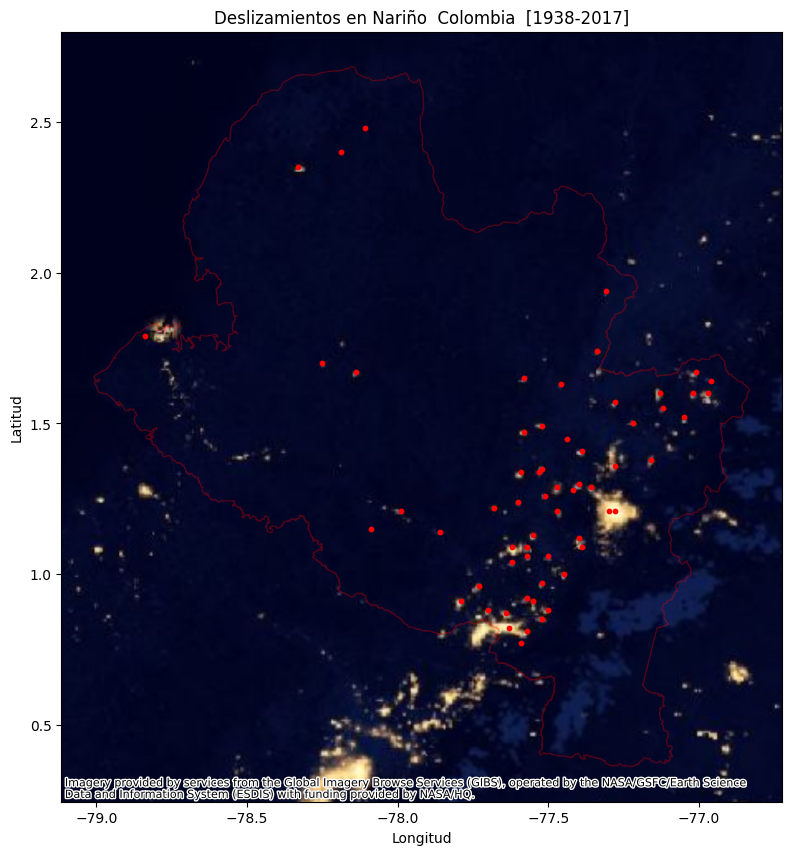

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_ylabel("Latitud")
ax.set_xlabel("Longitud")
ax.set_title("Deslizamientos en Nariño  Colombia  [1938-2017]")
# ax.add_artist(ScaleBar(100000,"m", location='lower right'))

# Plotear el departamento
narino_map.plot(ax=ax, alpha=0.3, edgecolor="red", facecolor="None")


# Agregar cada punto al mapa
for name, (lat, lon) in points_landslides_municipios.items():
    ax.scatter(lon, lat, color="red", s=10)
    # ax.text(lon, lat, name, fontsize=9, ha="center")


# Añadir el mapa base usando OpenStreetMap
ctx.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=ctx.providers.NASAGIBS.ViirsEarthAtNight2012,
    zoom=8,
)


# Mostrar el mapa
plt.show()

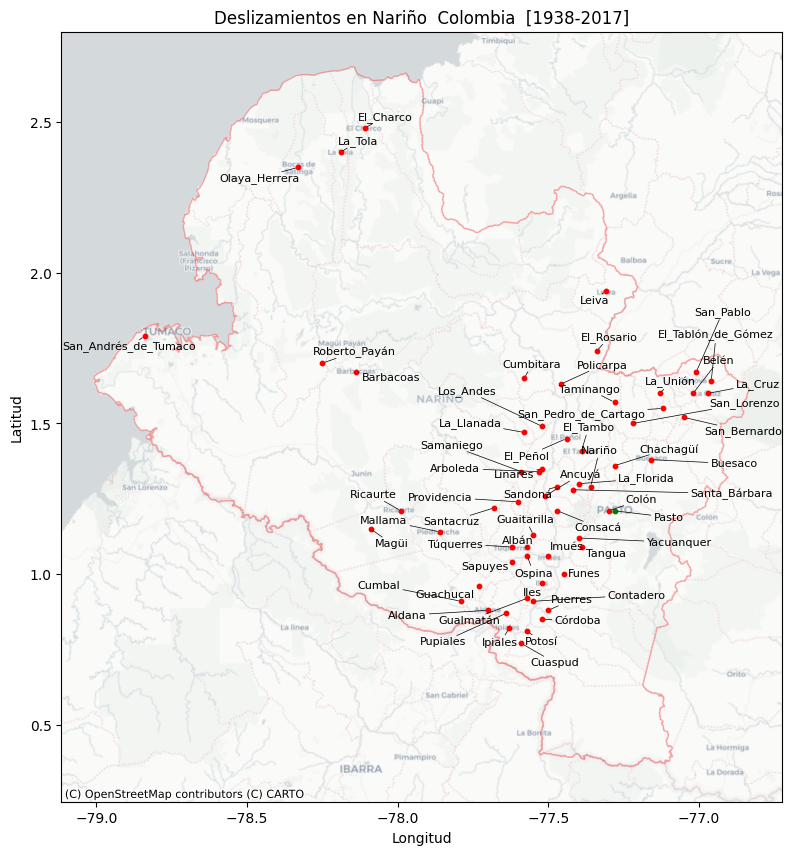

In [43]:
def remove_substring(text, substring="UNGRD-"):
    """
    Remove a specified substring from the given text.

    Parameters
    ----------
    text (str): The original text from which the substring will be removed.
    substring (str): The substring to remove from the text.

    Returns
    -------
    str: The text with the substring removed.
    """
    return text.replace(substring, "")


fig, ax = plt.subplots(figsize=(10, 10))

ax.set_ylabel("Latitud")
ax.set_xlabel("Longitud")
ax.set_title("Deslizamientos en Nariño  Colombia  [1938-2017]")
# ax.add_artist(ScaleBar(100000,"m", location='lower right'))

# Plotear el departamento
narino_map.plot(ax=ax, alpha=0.3, edgecolor="red", facecolor="None")

texts = []
# Agregar cada punto al mapa
for name, (lat, lon) in points_landslides_municipios.items():
    texts.append(ax.text(lon, lat, name, fontsize=8, ha="center", va="center"))
    if (lat, lon) == (round(1.2140275, 2), round(-77.2785096, 2)):
        ax.scatter(lon, lat, color="green", s=10)
        continue
    ax.scatter(lon, lat, color="red", s=10)
# Ajustar las posiciones de las etiquetas de texto para evitar superposiciones
adjust_text(
    texts,
    expand=(
        1.2,
        2,
    ),  # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
    arrowprops=dict(
        arrowstyle="-", color="k", lw=0.5
    ),  # ensure the labeling is clear by adding arrows
)
# Añadir el mapa base usando OpenStreetMap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
# Mostrar el mapa
plt.show()

In [2]:
def get_stations_total_dict(path_data):
    """get_stations_dict.

    get the stations from the csv file

    Parameters
    ----------
    pathData : str
        location of the csv file

    Returns
    -------
    station_dict: dict
        stations dictionary
    """
    df_stations = pd.read_csv(path_data)
    df_stations = df_stations.drop_duplicates(
        subset=["ubicaci_n__latitude", "ubicaci_n__longitude", "altitud"]
    )
    station_dict = {}
    for _, row in df_stations.drop_duplicates(subset=["nombre"]).iterrows():
        name_key = row["nombre"].split(" [")[0].replace(" ", "_")
        coords = (
            round(row["ubicaci_n__latitude"], 2),
            round(row["ubicaci_n__longitude"], 2),
            round(row["altitud"], 2),
        )
        station_dict[name_key] = coords
    return station_dict


location_stations = "../data/Original/IDEAM/estaciones.csv"

estaciones_totales = get_stations_total_dict(location_stations)
print(f"Total de estaciones: {len(estaciones_totales)} y son: {estaciones_totales}")

Total de estaciones: 152 y son: {'RUMICHACA_-_AUT': (0.81378611, -77.66197778, 2582), 'LA_JOSEFINA_-_AUT': (0.93030556, -77.49119444, 2450), 'EL_PARAISO_-_AUT': (1.07061111, -77.63688889, 3120), 'CERRO_PARAMO__-_AUT': (0.84311111, -77.38880556, 3585), 'LOS_NORTES_-_AUT': (1.74111111, -77.53111111, 340), 'TUMACO_-_AUT': (1.81930556, -78.73027778, 0), 'BIOTOPO_-_AUT': (1.40863889, -78.28161111, 512), 'GRANJA_EL_MIRA_-_-_AUT': (1.55019444, -78.69558333, 16), 'PUENTE_PUSMEO_-_AUT': (1.62405556, -77.47891667, 380), 'SAN_JUAN_MIRA_-_AUT': (1.42388889, -78.67027778, 2), 'Piedrancha_-_-_AUT': (1.14152778, -77.92897222, 1830), 'BOTANA_-_AUT': (1.16, -77.27880556, 2820), 'RICAURTE_-_AUT': (1.21533333, -77.99691667, 1210), 'VIENTO_LIBRE_-_AUT': (1.62, -77.34, 1400), 'UNIVERSIDAD_DE_NARINO__-_AUT': (1.23, -77.28, 2626), 'CHILES': (0.81166667, -77.84833333, 3100), 'AEROPUERTO_LA_FLORIDA': (1.8, -78.76666667, 3), 'AEROPUERTO_ANTONIO_NARINO': (1.39408333, -77.29086111, 1796), 'ALTAQUER_-_AUT': (1.248

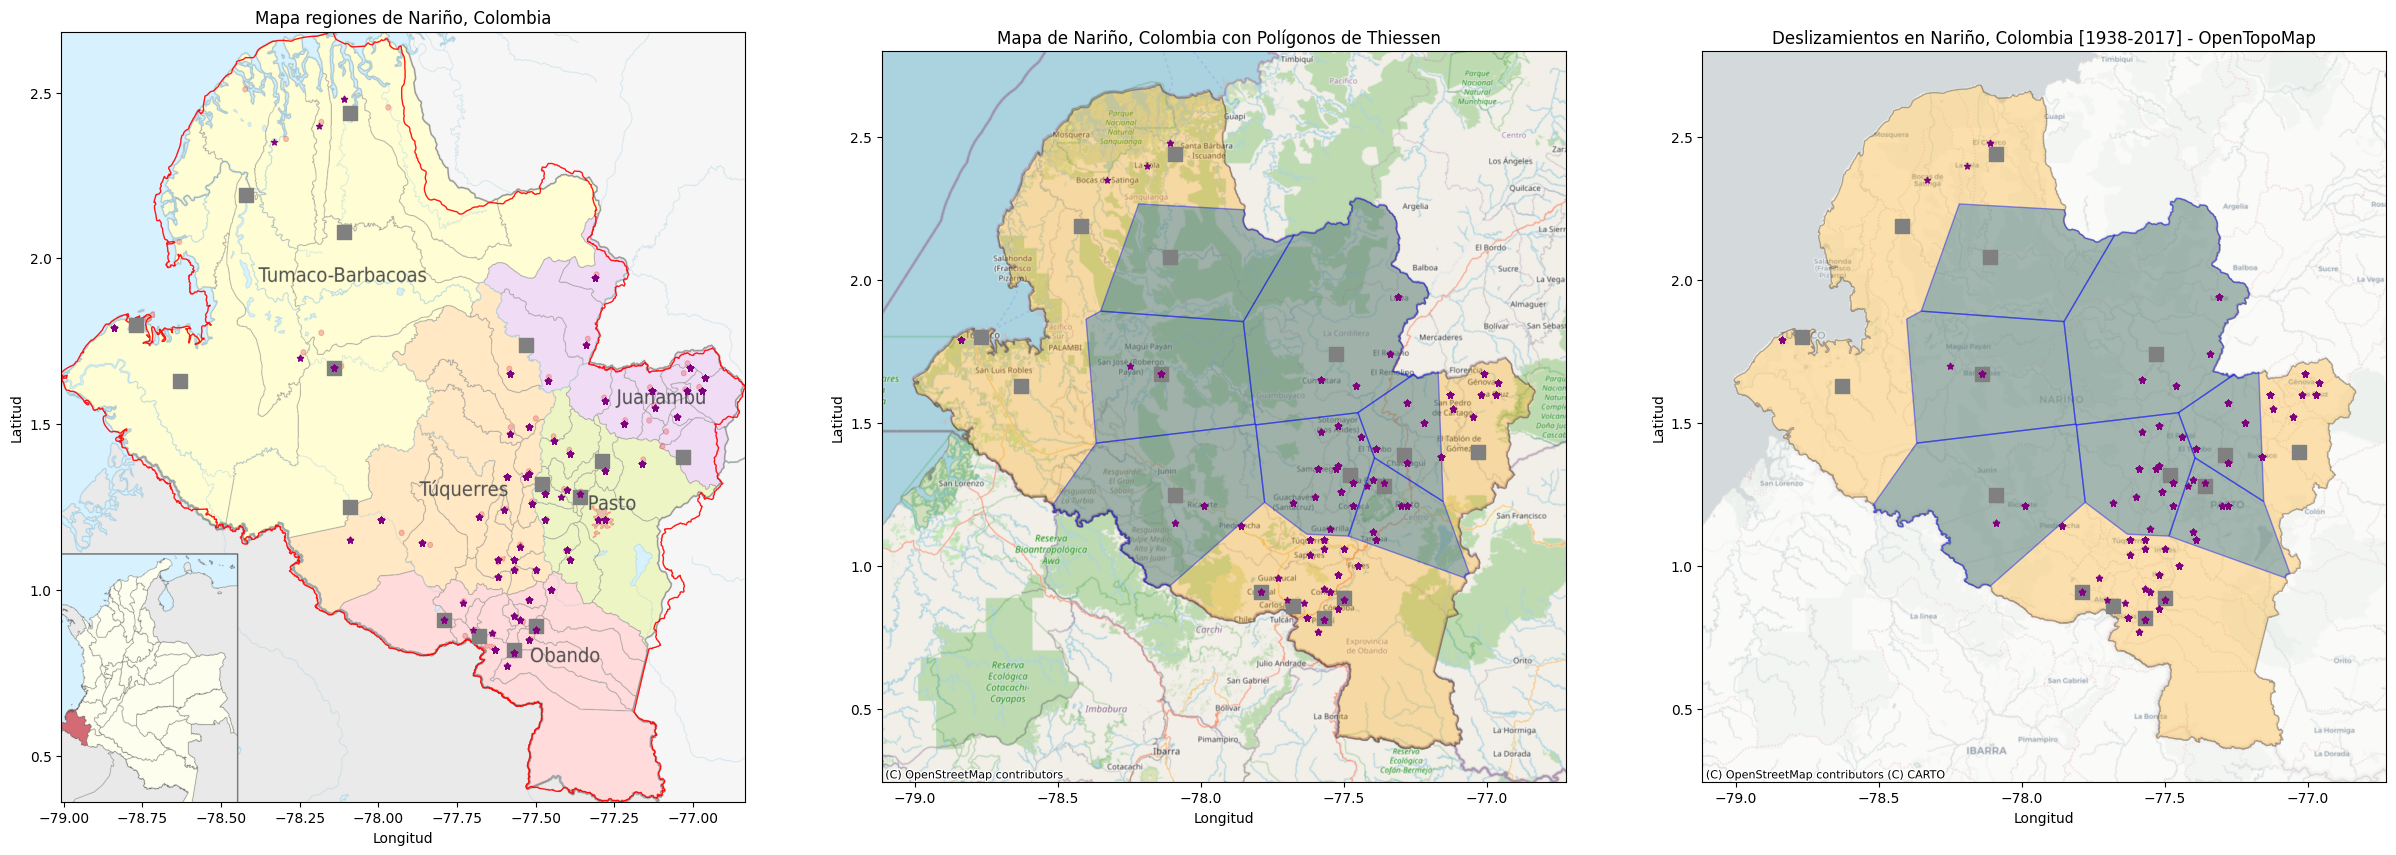

In [52]:
# Crear un GeoDataFrame para los puntos de deslizamientos
gdf_points = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lat, lon in estaciones.values()]
)
# Calcular los polígonos de Thiessen (Voronoi)
points = np.array([[lon, lat] for lat, lon in estaciones.values()])
vor = Voronoi(points)
delaunay = Delaunay(points)

lines = []
for simplex in delaunay.simplices:
    simplex_points = points[simplex]
    line = LineString(
        [
            (simplex_points[0, 0], simplex_points[0, 1]),
            (simplex_points[1, 0], simplex_points[1, 1]),
            (simplex_points[2, 0], simplex_points[2, 1]),
            (simplex_points[0, 0], simplex_points[0, 1]),
        ]
    )
    lines.append(line)
gdf_delaunay = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

polygons = []
for region in vor.regions:
    if -1 not in region and len(region) > 0:
        polygon = Polygon([vor.vertices[i] for i in region])
        polygons.append(polygon)
gdf_voronoi = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
# Cortar los polígonos de Thiessen a los límites de Nariño
gdf_voronoi_clipped = gpd.overlay(gdf_voronoi, narino_map, how="intersection")

# Crear la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
# Ajustar el tamaño de la figura
# Configuración general de los ejes
for ax in axs:
    ax.set_ylabel("Latitud")
    ax.set_xlabel("Longitud")

# Títulos de los subplots
axs[0].set_title("Mapa regiones de Nariño, Colombia")
axs[1].set_title("Mapa de Nariño, Colombia con Polígonos de Thiessen  ")
axs[2].set_title("Deslizamientos en Nariño, Colombia [1938-2017] - OpenTopoMap")

# Plotear el departamento en los tres subplots
narino_map.plot(ax=axs[0], alpha=0.9, edgecolor="red", facecolor="None")
narino_map.plot(ax=axs[1], alpha=0.3, edgecolor="k", facecolor="orange")
narino_map.plot(ax=axs[2], alpha=0.3, edgecolor="k", facecolor="orange")

# Plotear los polígonos de Thiessen en el segundo subplot
gdf_voronoi_clipped.plot(ax=axs[1], alpha=0.4, edgecolor="blue")
gdf_voronoi_clipped.plot(ax=axs[2], alpha=0.4, edgecolor="blue")
gdf_points.plot(ax=axs[1], color="None", markersize=100)
gdf_points.plot(ax=axs[2], color="None", markersize=100)
# Plotear la triangulación de Delaunay en el segundo subplot
# gdf_delaunay.plot(ax=axs[1], color='green', linewidth=0.5)

# Agregar cada punto al mapa
# Agregar cada punto al mapa
for name, (lat, lon) in estaciones.items():
    axs[0].scatter(lon, lat, color="grey", s=100, marker="s")
    axs[1].scatter(lon, lat, color="grey", s=100, marker="s")
    axs[2].scatter(lon, lat, color="grey", s=100, marker="s")

for name, (lat, lon) in points_landslides.items():
    # axs[0].scatter(lon, lat, color="purple", s=10, marker='*')
    axs[0].scatter(lon, lat, color="purple", s=20, marker="*")
    axs[1].scatter(lon, lat, color="purple", s=20, marker="*")
    axs[2].scatter(lon, lat, color="purple", s=20, marker="*")

# for name, (lat, lon) in estaciones_totales.items():
#     axs[1].scatter(lon, lat, color="cyan", s=6)


# Añadir una imagen como fondo en el primer subplot
img_path = (
    # "/Users/chocoplot/Documents/CodeLab/PYTHON/GeoENOS/Mapa_de_Narinio_politico.png"
    "/Users/chocoplot/Documents/CodeLab/PYTHON/GeoENOS/Mapa_de_Nariño_(subregiones).png"
)
img = mpimg.imread(img_path)
axs[0].imshow(
    img,
    extent=[
        narino_map.total_bounds[0],
        narino_map.total_bounds[2],
        narino_map.total_bounds[1],
        narino_map.total_bounds[3],
    ],
    aspect="auto",
    alpha=0.7,
)
# Añadir el mapa base a cada subplot
# ctx.add_basemap(
#     axs[0],
#     crs=gdf.crs.to_string(),
#     source=ctx.providers.OpenStreetMap.BlackAndWhite,
#     zoom=8,
# )

ctx.add_basemap(
    axs[1], crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik
)
ctx.add_basemap(axs[2], crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Mostrar el mapa
plt.show()

In [48]:
municipios_deslizamientos_sort = sorted(municipios_deslizamientos)
for muni in municipios_deslizamientos_sort:
    print(f"{muni}: {df_deslizamientos[df_deslizamientos['Municipio']==muni].shape[0]}")

Albán: 22
Aldana: 1
Ancuyá: 23
Arboleda: 29
Barbacoas: 17
Belén: 14
Buesaco: 26
Chachagüí: 15
Colón: 8
Consacá: 14
Contadero: 8
Cuaspud: 6
Cumbal: 7
Cumbitara: 16
Córdoba: 10
El Charco: 2
El Peñol: 10
El Rosario: 10
El Tablón de Gómez: 20
El Tambo: 18
Funes: 21
Guachucal: 3
Guaitarilla: 6
Gualmatán: 5
Iles: 14
Imués: 10
Ipiales: 31
La Cruz: 29
La Florida: 8
La Llanada: 8
La Tola: 1
La Unión: 34
Leiva: 15
Linares: 15
Los Andes: 17
Magüi: 4
Mallama: 13
Nariño: 5
NotRegister: 0
Olaya Herrera: 2
Ospina: 8
Pasto: 120
Policarpa: 13
Potosí: 16
Providencia: 6
Puerres: 11
Pupiales: 2
Ricaurte: 22
Roberto Payán: 2
Samaniego: 26
San Andrés de Tumaco: 14
San Bernardo: 11
San Lorenzo: 19
San Pablo: 27
San Pedro de Cartago: 8
Sandoná: 26
Santa Bárbara: 2
Santacruz: 10
Sapuyes: 9
Taminango: 14
Tangua: 14
Túquerres: 18
Yacuanquer: 11


In [2]:
import pandas as pd


def clean_data(df):
    # Derive column 'type_ENSO' from column: 'value_mei_v2'
    # niña:[]
    # neutro:(-0.5,0.5)
    # niño:[]
    df["value_mei_v2"] = pd.to_numeric(df["value_mei_v2"], errors="coerce")
    df["type_ENSO"] = df.apply(
        lambda row: "niña"
        if row["value_mei_v2"] < -0.5
        else ("neutro" if -0.5 <= row["value_mei_v2"] <= 0.5 else "niño"),
        axis=1,
    )
    return df


# Loaded variable 'df' from URI: /Users/chocoplot/Documents/CodeLab/PYTHON/GeoENOS/data/processed/NOAA/enso_process.csv
df = pd.read_csv(
    r"/Users/chocoplot/Documents/CodeLab/PYTHON/GeoENOS/data/processed/NOAA/ALL_ENSODATA.csv"
    # r"/Users/chocoplot/Documents/CodeLab/PYTHON/GeoENOS/data/processed/NOAA/enso_process.csv"
)

df_clean = clean_data(df.copy())
df_clean.head()
df_clean.to_csv("All_ENSODATA.csv", index=False)
